# Earthquake detector... IN SPACE! 

By: Francesco Civilini

Hello everyone, and welcome back to another Deep Learning experiment! We are going to be expanding on the concepts built up from the last two posts and use the earthquake detector model to predict wave arrivals. However, we're going to add an extra twist this time. Instead of earthquakes, we will be detecting moonquakes from seismometers deployed during the Apollo missions! Exciting huh? It's an application that's really out of this world! Sorry, I'll do my best to keep the space puns at a minimum...

All jokes aside, tasks like this are what planetary science is all about: using techniques that worked on Earth and using them to get information on other planetary bodies. To use what what we know and boldly go where no seismologist has... you get the idea.  


<img src="https://moon.nasa.gov/system/resources/detail_files/13_371255main_Seismic_1600.jpg">
[Image credit to NASA]

First off, a big thank you to Dr. Jesse-Lee Dimech, Research Scientist at Geoscience Australia, and Dr. Renee Weber, Planetary Scientist and Manager at the Heliophysics and Planetary Science Office at NASA Marshall Space Flight Center, for kindly giving me access to the data. Make sure to follow Dr. Weber on twitter (`@moonshakes`) for updates on all things Moon and Mars seismology! 

Let's talk a little bit about moonquakes. On Earth, earthquakes correspond to the energy release caused by friction from rock masses sliding past each other. On the moon, seismic energy is caused by thermal stresses due to heating from the sun or from meteriorite impacts (since it has no atmosphere to burn up the debris). 

Ground shaking recorded by receivers is primarily a mix (or convolution) of three functions: the source that causes the energy release, the path which the waves travel to get to the receiver, and the near surface geology at the receiver. The geology of the moon is much more weathered, so the seismic energy that we can expect at our receiver is much more attenuated than what we would observe on Earth. 

The main questions we will try to answer will be:
-  Can we apply our Deep Learning, Earth-based earthquake model to detect moonquakes? Are Earth-based seismic events a good analogue for planetary seismology?
-  Can we predict the time that seismic wave arrivals occur?

And important thing to keep in mind is that this example is a fun proof-of-concept, and isn't expected to stand up to the rigorous standards of a publication. Our current model is based on one-second interval spectrograms, and that temporal accuracy is not sufficient for most kinds of seismological analysis. Additionally, our model is based on a single earth station (only one type of geology) whose accuracy of P-wave arrival times are nebulous at best. If we were doing this experiment to stand up to publication scrutiny, we would be spending weeks trying to find the optimal temporal resolution of the spectrograms for the training models.

That being said, let's have some fun!

## What do Moonquakes look like?

We begin by looking at some data. As mentioned in the last post, ObsPy is a good place to start but we will want to design plotting routines ourselves. Hopefully most of this code will look very familiar to those that went through my last post. 

In [24]:
# Import packages
from obspy.core import read
import glob
import numpy as np
import random
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import cm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from fastai.vision import *
from fastai.metrics import error_rate
import matplotlib as mpl
from joblib import Parallel, delayed
from IPython.display import HTML
import pandas as pd
import shutil
import logging
from importlib import reload 

/home/francesco/anaconda3/envs/fc_fastai/lib/python3.7/site-packages/matplotlib/dates.py:1323: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  ' Defaulting to {0}.'.format(interval))


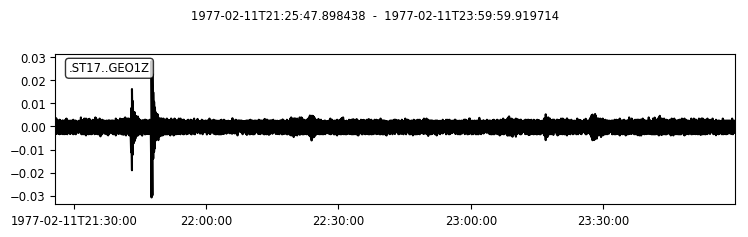

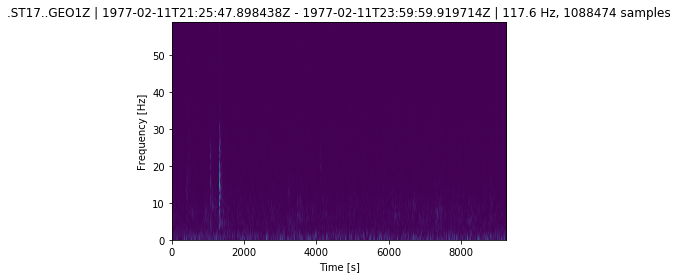

         network: 
         station: ST17
        location: 
         channel: GEO1Z
       starttime: 1977-02-11T21:25:47.898438Z
         endtime: 1977-02-11T23:59:59.919714Z
   sampling_rate: 117.64704895019531
           delta: 0.008500000713348449
            npts: 1088474
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.0085000005, 'depmin': -0.030748198, 'depmax': 0.028279454, 'b': 77147.898, 'e': 86399.922, 'depmen': -5.3723521e-05, 'nzyear': 1977, 'nzjday': 42, 'nzhour': 0, 'nzmin': 0, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 1088474, 'iftype': 1, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'unused23': 0, 'kstnm': 'ST17    ', 'kevnm': '                ', 'kcmpnm': 'GEO1Z'})

In [2]:
# Select the data folder
data_folder = '/media/francesco/Elements/ML_projects/apollo_data/3-despiked/'

# Our files are SAC format this time (instead of MSEED)
files = glob.glob(f'{data_folder}*.SAC')

# Let's take a test file.
testfile = files[159]
ind = 159
st = read(files[ind])
tr = st[0]

# Uncomment the line below to plot a random signal instead of the one that I chose
# ind = random.randint(0,len(files))
trace = tr.plot()
spect = tr.spectrogram()
tr.stats

Ok, so it looks like there is a lot of noise in the signal, which is pretty understandable considering it was recorded in the 70s and it *came from the moon*! Looking at the spectrogram, it's relatively clear that the noise is due to low frequencies, although it's difficult to tell due to the ObsPy plotting tools. The `.stats` variable gives us the usual information that we need to plot the functions, it's just organized in a slightly different way due to the SAC format.    

## Use our own plotting tools for the Moonquakes

Let's use our combined seismic and spectral trace code from last time. 

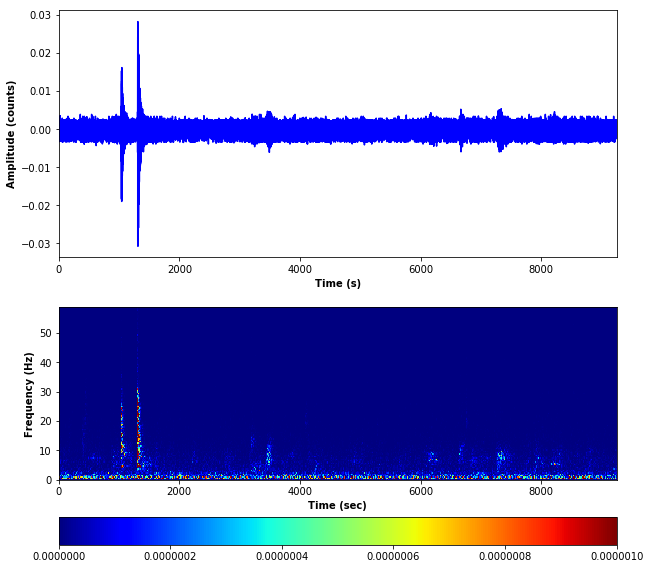

In [3]:
def plot_seismo_spectro(input_trace):
    
    # Convert the time of the input trace from matplotlib to seconds
    time = (input_trace.times("matplotlib")-input_trace.times("matplotlib")[0])*86400
    
    # Compute the spectrogram
    f, t, Sxx = signal.spectrogram(input_trace.data, input_trace.stats.sampling_rate)
    
    # Plot
    fig = plt.figure(figsize =(10,10))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(time, input_trace.data, "b-")
    plt.ylabel('Amplitude (counts)', fontweight = 'bold')
    plt.xlabel('Time (s)', fontweight = 'bold')
    plt.xlim((time[0], time[-1]))
    
    ax2 = fig.add_subplot(2, 1, 2)
    specmax = 1e-6
    plt.pcolormesh(t, f, Sxx, cmap=cm.jet, vmax=specmax)
    plt.ylabel('Frequency (Hz)', fontweight='bold')
    plt.xlabel('Time (sec)', fontweight='bold') 
    plt.colorbar(orientation='horizontal')
    
    plt.show()
    plt.close(fig)
    
    return

plot_seismo_spectro(tr)

Cool, well that looks much better! So we can clearly see the low-frequency noise present throughout the entire record. Note that we needed to change out `vmax` variable for the spectrogram, as the energy recorded here is much lower than what we had on Earth.

We need to think ahead for correctly applying our Earth-based model. That model was based on recorded seismicity in California, which does not have this low-frequency background signal. If we augment and feed in these spectrograms, our model will falsely predict seismic activity to be happening all the time! 

To get around this, we will apply a highpass filter, which attenuates all frequencies below a certain threshold frequency. In this case, we will attenuate all frequencies below 5 Hz.

In [2]:
def plot_seismo_spectro_bounds(input_trace, input_min, input_max):
    
    # Convert the time of the input trace from matplotlib to seconds
    time = (input_trace.times("matplotlib")-input_trace.times("matplotlib")[0])*86400
    
    # Compute the spectrogram
    f, t, Sxx = signal.spectrogram(input_trace.data, input_trace.stats.sampling_rate)

    fig = plt.figure(figsize =(10,10))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(time, input_trace.data, "b-")
    plt.ylabel('Amplitude (counts)', fontweight = 'bold')
    plt.xlabel('Time (s)', fontweight = 'bold')
    plt.xlim((input_min, input_max))
    
    ax2 = fig.add_subplot(2, 1, 2)
    specmax = 1e-6
    plt.pcolormesh(t, f, Sxx, cmap=cm.jet, vmax=specmax)
    plt.ylabel('Frequency (Hz)', fontweight='bold')
    plt.xlabel('Time (sec)', fontweight='bold')
    plt.xlim((input_min, input_max))
    plt.colorbar(orientation='horizontal')
    
    plt.show()
    plt.close(fig)
    
    return

What happens if we remove some of the noise via a highpass filter?

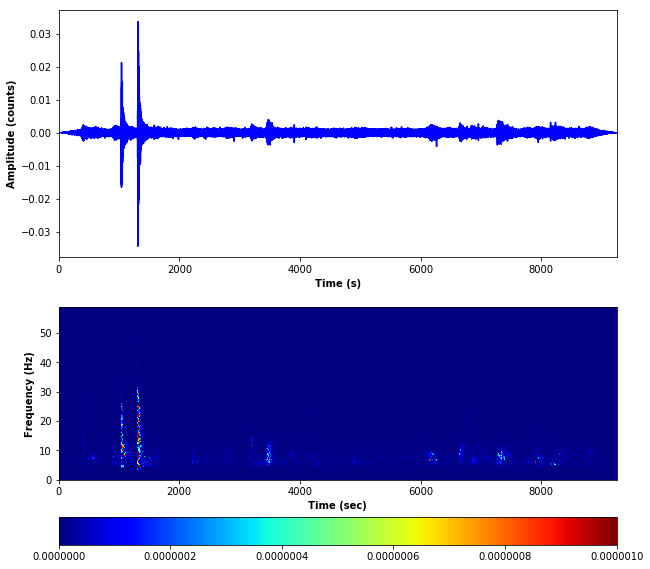

In [6]:
# Before we apply the highpass filter, we need to remove the mean and apply a taper
trace_nomean = tr.data-np.mean(tr.data)
N = len(trace_nomean)
taper_function = cosine_taper(N, p=0.1)
trace_taper = trace_nomean * taper_function

# # Highpass filterbound in Hertz
highpass_filtbound = 5
data_filt = highpass(trace_taper, highpass_filtbound, tr.stats.sampling_rate, corners=4, zerophase=False)
tr_filt = tr
tr_filt.data = data_filt

plot_seismo_spectro(tr_filt)

Well, that looks better! However, this is a lot of data (over 2 hours!), which can be a lot to manage after we apply data-augmentation. For right now, let's work on a small subset.

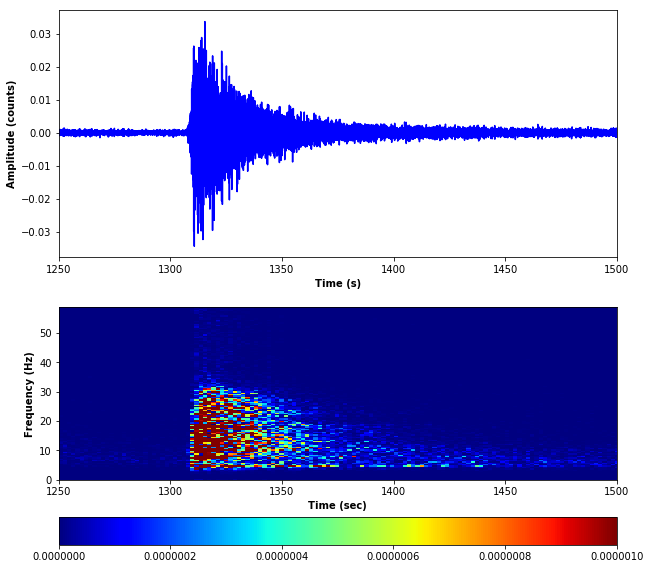

In [7]:
plot_seismo_spectro_bounds(tr_filt, 1250, 1500)

We can clearly see that there is still noise up to 10 Hz from 1250-1300 seconds. Additionally, the moonquake frequencies taper out at approximatly 30 Hz, while our Earth-based seismicity extended up to 50 Hz. This is due to the weathered Lunar geology, which quickly attenuates high frequencies.  

## Use the Earth-based model to detect moonquakes

Before we apply the model, I need to mention a relatively important error I made last post that I didn't notice, but repeatedly crashed my codes this time around. As it turns out, Matplotlib has problems clearing figures within a `for` loop. Despite doing `fclose()`, it still does not properly clear the memory. Fortunately, github user Akshaypatil15 had a fix described here that worked for me:

https://github.com/matplotlib/matplotlib/issues/8560/

Apparently, you have to `plt.show()` the image first to clear it properly. Just something to be mindful of. 

Let's take our test file, run a highpass filter, do data augmentation, and see what we get! Let's do an experiment and run this twice, with 5 Hz highpass and 10 Hz highpass. Our functions are organized a little bit different than last time so they can run in parallel, but they are essentially the same. 

In [48]:
# Plots a 20-second spectrogram (will be compared with our model)

def plot_spectrogram_segment(input_trace, f_input, t_input, Sxx_input, in_start, in_end, input_path):
    
    filename = (f'model_{input_trace.stats.network}_{input_trace.stats.station}_'
                f'{input_trace.stats.channel}_{input_trace.stats.starttime}_'
                f'{in_start}_{in_end}.png')
    
    if not os.path.exists(f'{runtime_path}tmp/'):
        os.mkdir(f'{runtime_path}tmp/')

    specmax = 1e-6
        
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.pcolormesh(t_input, f_input, Sxx_input, cmap=cm.jet, vmax=specmax)
    plt.xlim((float(in_start), float(in_end)))

    plt.axis('off')
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)

    fig.savefig(f'{input_path}tmp/{filename}')

    plt.clf()
    
    plt.show(block=False)
    plt.close('all')
    
    return

In [3]:
# Run a highpass filter through the data

def run_highpass_filter(input_data, input_corner_freq):
    
    # Remove the mean and run a cosine taper
    trace_nomean = input_data.data-np.mean(input_data.data)
    N = len(trace_nomean)
    taper_function = cosine_taper(N, p=0.1)
    trace_taper = trace_nomean * taper_function

    # Highpass filterbound in Hertz
    data_filt = highpass(trace_taper, input_corner_freq, input_data.stats.sampling_rate, corners=4, zerophase=False)
    tr_filt = input_data
    tr_filt.data = data_filt
        
    return tr_filt

In [10]:
# Set the path
runpath = '/media/francesco/Elements/ML_projects/apollo_runtime/'

# Get our original test file
testfile = '/media/francesco/Elements/ML_projects/apollo_data/3-despiked/DI.GEO1Z.77.02.11.21.25.SAC'
testfile_bn = os.path.basename(testfile)

# Reload the variables (so it's not dependent on the highpass filter we ran before)
st = read(testfile)
tr = st[0]

# Run a 5Hz or 10Hz highpass filter on the trace the trace
# trace_filtered = run_highpass_filter(tr, 5)
trace_filtered = run_highpass_filter(tr, 10)

# Run a spectrogram on the entire trace
f, t, Sxx = signal.spectrogram(trace_filtered.data, trace_filtered.stats.sampling_rate)

# Set upper and lower bounds right now so we don't run the whole trace
lower_bound = 1250
upper_bound = 1500
# upper_bound = int(tr.stats.npts / tr.stats.sampling_rate)

# Make an output directory based on the filename
runtime_path = f'/media/francesco/Elements/ML_projects/apollo_runtime/{testfile_bn}/'
if not os.path.exists(runtime_path):
    os.mkdir(runtime_path)

# Load our Earth-based learner
learn = load_learner('/home/francesco/Dropbox/machine_learning/eq_detector_moon/')

# Set the times and iterations for the data augmentation (20 second windows like our model)
start_times = np.arange(lower_bound,upper_bound-20)
end_times = np.arange(lower_bound+20,upper_bound)
iterations = np.arange(len(start_times))


In [11]:
%%capture

# Plot the spectrograms 
num_cores = 7
Parallel(n_jobs=num_cores)(delayed(plot_spectrogram_segment)(trace_filtered, f, t, Sxx, start_times[iteration], end_times[iteration], runtime_path) 
                           for iteration in iterations)

In [12]:
%%capture
# Run the predictions for each file. 
# These variables will be more important in the next section

filelist = glob.glob(f'{runtime_path}tmp/*.png')
file_vector, classify_vector, idx_vector, outputs_vector = [], [], [], []

for testimage in filelist:
    
    image_bn = os.path.basename(testimage)
    file_vector.append(image_bn)
    
    img = open_image(testimage)    
    classify, idx, outputs = learn.predict(img)
    
    classify_vector.append(classify)
    idx_vector.append(idx)
    outputs_vector.append(outputs)
    
    print(f'Ran prediction for {image_bn}...')


In [4]:
# Plot the result from the probabilities

def plot_result(input_trace, input_start, input_end, input_lower_bound, input_upper_bound, input_f, input_t, input_Sxx):
    
    # Extract a good filename for the data
    filename = (f'model_{input_trace.stats.network}_{input_trace.stats.station}_'
                f'{input_trace.stats.channel}_{input_trace.stats.starttime}_'
                f'{input_start}_{input_end}.png')
    
    # Output time in matlplotlib format and find out the current time window indices
    time = (input_trace.times("matplotlib")-input_trace.times("matplotlib")[0])*86400
    input_start_ind = int((input_trace.stats.sampling_rate * input_start))
    input_end_ind = int((input_trace.stats.sampling_rate * input_end))
    
    # Find the probability from the saved variables
    plot_ind = np.where(np.array(file_vector)==filename)[0][0]
    plot_class = classify_vector[plot_ind]
    plot_idx = idx_vector[plot_ind]
    plot_outputs = outputs_vector[plot_ind]
    
    probability = f'{np.round(plot_outputs[plot_idx].data.item()*100,2)}%'
    
    # This is the classification scheme in our DL model
    if plot_idx==0:
        classification = 'earthquake'
    else:
        classification = 'noise'
    
    # Plot the result
    fig = plt.figure(figsize=(12,7))
    ax1 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=1)
    ax1.plot(time, input_trace.data, "b-")
    
    if plot_idx == 0:
        ax1.plot([input_start, input_end, input_end, input_start, input_start],
                 [np.min(input_trace.data),np.min(input_trace.data), np.max(input_trace.data), np.max(input_trace.data), np.min(input_trace.data)], 
                 c='red')
    else:
        ax1.plot([input_start, input_end, input_end, input_start, input_start],
                 [np.min(input_trace.data),np.min(input_trace.data), np.max(input_trace.data), np.max(input_trace.data), np.min(input_trace.data)], 
                 c='gray')

    plt.ylabel('Amplitude (counts)', fontweight = 'bold')
    plt.xlabel('Time (s)', fontweight = 'bold')
    plt.xlim((input_lower_bound, input_upper_bound))
    
    output_str = f'Prediction: {classification} - {probability} confidence'    
    plt.title(output_str)
    
    ax2 = plt.subplot2grid((2,3), (0,2), colspan=1, rowspan=1)
    ax2.plot(time, input_trace.data, "b-")
    plt.ylabel('Amplitude (counts)', fontweight = 'bold')
    plt.xlabel('Time (s)', fontweight = 'bold')
    plt.xlim((time[input_start_ind],time[input_end_ind]))
    
    ax3 = plt.subplot2grid((2,3), (1,2), colspan=1, rowspan=1)
    specmax = 1e-6
    ax3.pcolormesh(input_t, input_f, input_Sxx, cmap=cm.jet, vmax=specmax)
    plt.ylabel('Frequency (Hz)', fontweight='bold')
    plt.xlabel('Time (sec)', fontweight='bold')
    plt.xlim((time[input_start_ind], time[input_end_ind]))    
    
    ax4 = plt.subplot2grid((2,3), (1,0), colspan=1, rowspan=1)
    ax4.axis('off')
    ax4.get_xaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)
    
    if plot_idx==0:
        plt.text(0.5, 0.5, output_str, fontweight='bold', bbox=dict(facecolor='red', alpha=0.5), 
                 verticalalignment='center', transform=ax4.transAxes, size=15)
    else:
        plt.text(0.5, 0.5, output_str, fontweight='bold', bbox=dict(facecolor='gray', alpha=0.5), 
                 verticalalignment='center', transform=ax4.transAxes, size=15)        

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.5)
    
    plt.savefig(f'{runtime_path}{filename}', bbox_inches='tight')
    
    plt.clf()
    plt.show(block=False)
    plt.close('all')
   
    print(f'Saved {filename}...')
    
    return

In [14]:
%%capture

# Now plot the results of the probabilities
num_cores = 7
Parallel(n_jobs=num_cores)(delayed(plot_result)(trace_filtered, start_times[iteration], end_times[iteration], 
                                                 lower_bound, upper_bound, f, t, Sxx) for iteration in iterations)

In [9]:
# We can use the same utility as last time to convert the images to a gif. 
!convert -delay 100 -loop 0 $(ls -1 {runtime_path}*.png | sort -V) model_run.gif

In [7]:
# 5 Hz result
HTML('<img src="testfile_5hz_highpass.gif">')

In [8]:
# 10 High highpass
HTML('<img src="testfile_10hz_highpass.gif">')

It seems like it all worked quite well! The 5 Hz has more occasional false detections, so we will stick with the 10 Hz high-pass data from here on out. 

## Marking Detections

Ok, now we have the detector code working for the moonquakes, but how do we go from that to detections?

The algorithm goes as follow:
-  Plot the spectrograms for each 20 second interval
-  Calculate the probabilities
-  Find where in the output probabilities the intervals go from noise to earthquake. 

Not bad eh? Two out of the three steps are the same! After we determine the arrivals, we will plot them into a figure and save the time stamp of them into a text file. 

Let's run this the same file we looked at before, but instead let's use more of the signal this time. 

In [4]:
%%capture
# Set the paths and the testfile we will be using
runtime_path = '/media/francesco/Elements/ML_projects/apollo_detections/'
detection_output = '/media/francesco/Elements/ML_projects/apollo_detection_outputs/'
testfile = '/media/francesco/Elements/ML_projects/apollo_data/3-despiked/DI.GEO1Z.77.02.11.21.25.SAC'

# Find the basename of the trace and read it in
testfile_bn = os.path.basename(testfile)
st = read(testfile)
tr = st[0]

# We get the absolute date time here because it takes a surprisingly long amount of time to calculate
utc_time = tr.times("utcdatetime")

# Run a 10Hz highpass filter on the trace the trace
trace_filtered = run_highpass_filter(tr, 10)

# Run a spectrogram on the entire trace (that way we don't get in trouble with the xlimits)
# This is ok because we're only doing this once at the beginning
f, t, Sxx = signal.spectrogram(trace_filtered.data, trace_filtered.stats.sampling_rate)

# Change the lower and upper bounds in case we want to work on subsets
lower_bound = 900
upper_bound = 1500
# upper_bound = int(tr.stats.npts / tr.stats.sampling_rate)

# Often times we will be testing various intervals or filters
# It's important to remove the spectrograms before continuing 
if os.path.exists(f'{runtime_path}{testfile_bn}/'):
    shutil.rmtree(f'{runtime_path}{testfile_bn}/')
os.mkdir(f'{runtime_path}{testfile_bn}/')

# Set a new runtime path
runtime_path = f'{runtime_path}{testfile_bn}/'

# Load the learner
learn = load_learner('/home/francesco/Dropbox/machine_learning/eq_detector_moon/')

# One more thing we didn't do before. 
# We have to change the precision of the start time numbers. 
# If not, glob can get confused sometimes... 
start_times_init = np.arange(lower_bound,upper_bound-20)
end_times_init = np.arange(lower_bound+20,upper_bound)
start_times, end_times = [], []
for start_time in start_times_init:
    start_times.append("%05d" % (start_time,))
for end_time in end_times_init:
    end_times.append("%05d" % (end_time,))

# Set the iterations
iterations = np.arange(len(start_times))

I know that was a large block of text, but it's just setting up the spectrogram plotting code like always. 

In [5]:
%%capture
# Plot the spectrograms 
num_cores = 7
Parallel(n_jobs=num_cores)(delayed(plot_spectrogram_segment)(trace_filtered, f, t, Sxx, start_times[iteration], end_times[iteration]) 
                           for iteration in iterations)

In [7]:
# Obtain probabilities from the spectograms
filelist = sorted(glob.glob(f'{runtime_path}tmp/*.png'))
file_vector, classify_vector, idx_vector, outputs_vector = [], [], [], []

for testimage in filelist:
    
    image_bn = os.path.basename(testimage)
    file_vector.append(image_bn)
    
    img = open_image(testimage)    
    classify, idx, outputs = learn.predict(img)
    
    classify_vector.append(classify)
    idx_vector.append(idx.data.item())
    outputs_vector.append(outputs)

Now comes the fun part. We have to take our probability output (`idx_vector`) and figure out to destinguish the vector to split up the noise from the earthquake. There are many different ways to do this, but I decided to use a probability threshold for noise and earthquake windows. Ok, what does that mean?

Imagine we're traveling forward time observing the elements of `idx_vector`. We will mostly have a values of 1 (noise), until we hit our earthquake, where we should have consecutive values of 0 (earthquake). Now, let's take a window `input_len_noise` of length 60 (seconds) and travel across the vector. If we reach a point where we had 60 seconds of noise and then come across 30 seconds of earthquake detections (`input_len_eq = 30`), then we probably found the transition from noise to earthquake. 

However, our model is not perfect, and we will get wrong labels occasionally. We introduce a variable called `input_confidence`, a percentage of incorrect elements within our noise or earthquake windows that we will tolerate. For example, if we have `input_confidence = 0.9` and windows `input_len_eq = 30` and `input_len_noise = 30`, we will accept up to 3 noise frames within our earthquake window and 3 earthquake frames in our noise window.

However, this method has an important caveat. If we have this kind of algorithm, we will get multiple detections across the first arrival. To combat this, I use the variable `duplicate_thresh` or the number of frames that are ignored after a first detection. 


In [5]:
# This is the detection algorithm I describe above

def consecutive_algorithm_tresh(input_utc_time, input_file_vector, input_end_times, input_idx, input_len_noise, input_len_eq, input_confidence, duplicate_thresh):
    
    # Convert the end times into numbers (our previous format was string)
    end_times_calc = []
    for end_time in end_times:
        end_times_calc.append(float(end_time))
    
    # Initialize the variables and run through all of the indices
    out_relative_detection_ind, out_relative_time, out_absolute_time = [], [], []
    for ind in np.arange(len(input_idx)-input_len_noise-input_len_eq):
        
        # Confidence deviation threshold
        confidence_deviation = 1-input_confidence
        if np.sum(input_idx[ind:ind + input_len_noise]) >= input_len_noise*input_confidence and np.sum(input_idx[ind + input_len_noise:ind + input_len_noise + input_len_eq]) <= input_len_eq*confidence_deviation:
            
            # If the vectors are empty, just go ahead and add the elements
            if len(out_relative_detection_ind) == 0:
                out_relative_detection_ind.append(ind + input_len_noise + 1)
                out_relative_time.append(end_times_calc[ind + input_len_noise + 1])
                out_absolute_time.append(utc_time[ind + input_len_noise + 1])
            else:
                # Apply the threshold to make sure that we don't have multiple detections for the same earthquake
                if end_times_calc[ind + input_len_noise] > np.max(out_relative_time) + duplicate_thresh:
                    out_relative_detection_ind.append(ind + input_len_noise + 1)
                    out_relative_time.append(end_times_calc[ind + input_len_noise + 1])
                    out_absolute_time.append(utc_time[ind + input_len_noise + 1])
        
    return out_relative_detection_ind, out_relative_time, out_absolute_time

In [96]:
# Run the detection algorithm
det_ind, det_rel_time, det_abs_time = consecutive_algorithm_tresh(utc_time, file_vector, end_times, idx_vector, 30, 30,.90, 20)

The next thing we will want to do is write down the detections calculated by our algorithm. In addition to creating a helpful log, we will use these files to add picks to each plot. 

In [6]:
# Export the detections into a text file

def export_txt_output(input_relative_time, input_absolute_time, input_basename):
    
    # Create a directory for the files and images (if it doesn't exist yet)
    if not os.path.exists(f'{detection_output}files/'):
        os.mkdir(f'{detection_output}files/')
    if not os.path.exists(f'{detection_output}images/'):
        os.mkdir(f'{detection_output}images/')
    
    # Save a text file
    np.savetxt(f'{detection_output}files/{testfile_bn[0:-4]}.txt', np.c_[det_rel_time, det_abs_time], 
               header="rel_time,abs_time", delimiter=',', fmt="%s")
    
    return

In [98]:
# Export the text detections
export_txt_output(det_rel_time, det_abs_time, testfile_bn)

Lastly, we plot the detections obtained from the text file. 

In [7]:
def plot_seismo_spectro_bounds_dets(input_trace, input_min, input_max, input_relative_detections, output_directory, input_basename):
    
    # Convert the time of the input trace from matplotlib to seconds
    time = (input_trace.times("matplotlib")-input_trace.times("matplotlib")[0])*86400
    
    # Compute the spectrogram
    f, t, Sxx = signal.spectrogram(input_trace.data, input_trace.stats.sampling_rate)

    fig = plt.figure(figsize =(10,10))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(time, input_trace.data, "b-")
    plt.ylabel('Amplitude (counts)', fontweight = 'bold')
    plt.xlabel('Time (s)', fontweight = 'bold')
    plt.xlim((input_min, input_max))
    for rel_det in input_relative_detections:
        plt.axvline(x=rel_det, c='r')
    plt.title(input_basename, fontweight='bold')
    
    ax2 = fig.add_subplot(2, 1, 2)
    specmax = 1e-6
    plt.pcolormesh(t, f, Sxx, cmap=cm.jet, vmax=specmax)
    plt.ylabel('Frequency (Hz)', fontweight='bold')
    plt.xlabel('Time (sec)', fontweight='bold')
    plt.xlim((input_min, input_max))
    for rel_det in input_relative_detections:
        plt.axvline(x=rel_det, c='r')
        
    plt.colorbar(orientation='horizontal')
    
    fig.savefig(f'{output_directory}/{input_basename}.png', dpi=250)
    
    # If you want to show the plot, uncomment the line below
#     plt.show()
    
    # Uncomment the following two lines during production
    # (To prevent memory leaks)
    plt.clf()
    plt.show(block=False)
    
    plt.close('all')
    
    return

def plot_detections(input_trace, input_basename, input_lower_bound, input_upper_bound, input_textfile_directory, input_image_directory):
    
    detection_filename = glob.glob(f'{input_textfile_directory}{input_basename[0:-4]}.txt')
    
    # If we have no detections, return the function
    if len(detection_filename) == 0:
        print(f'No detections for {input_basename}...')
        return
    
    # Import the detections into a pandas dataframe and obtain the values
    df = pd.read_csv(detection_filename[0])
    det_relative = df['# rel_time'].values
    det_abs = df['abs_time'].values
    
    # Plot the data using a variation of our first plotting function
    plot_seismo_spectro_bounds_dets(input_trace, input_lower_bound, input_upper_bound, det_relative, input_image_directory, input_basename)
    
    return

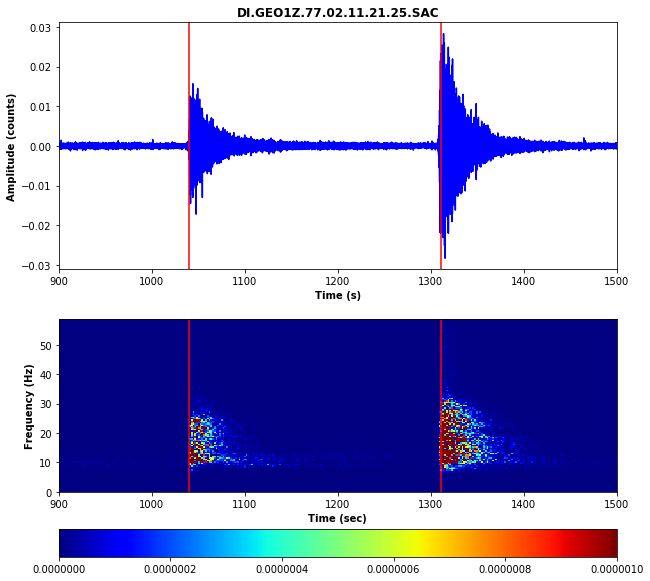

Finished analysis for DI.GEO1Z.77.02.11.21.25.SAC: 2 detections


In [100]:
# Save the plots
plot_detections(tr, testfile_bn, lower_bound, upper_bound, f'{detection_output}files/', f'{detection_output}images/')

print(f'Finished analysis for {testfile_bn}: {len(det_ind)} detections')

We're all done! As you can see both major moonquakes are found using this code. The second moonquake (at approximately 1300 seconds) is detected a bit late, which is a mistake characteristic of our model that was observed even last week with earthquakes. The most important parameters are the earthquake and noise window lengths and confidence threshold in the function `consecutive_algorithm_tresh`. Playing around with those parameters will slightly change the picks. 

We have proved that our rough Earth model of seismicity, based on a single seismic station in California, is good enough to detect first arrivals of moonquakes. 

## Moonquake detection - fully automated script

In [ ]:
# Set a logger that we can see despite starting off with %%capture
reload(logging)
logger = logging.getLogger()
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

runpath = '/media/francesco/Elements/ML_projects/apollo_detections/'
detection_output = '/media/francesco/Elements/ML_projects/apollo_detection_outputs/'

sac_filelist = glob.glob(f'/media/francesco/Elements/ML_projects/apollo_data/3-despiked/*.SAC')
# sac_filelist = glob.glob(f'/media/francesco/Elements/ML_projects/apollo_data/3-despiked/DI.GEO1Z.76.08.18.11.59.SAC')


for testfile in sac_filelist:
    testfile_bn = os.path.basename(testfile)
    
    if os.path.exists(f'{detection_output}images/{testfile_bn}.png'):
        logging.debug(f'{testfile_bn} already done...')
    else:
        logging.debug(f'Running {testfile_bn}...')

        st = read(testfile)
        tr = st[0]

        # We get the absolute date time here because it takes a surprisingly long amount of time to calculate
        utc_time = tr.times("utcdatetime")

        # Run a 10Hz highpass filter on the trace the trace
        trace_filtered = run_highpass_filter(tr, 10)

        # Run a spectrogram on the entire trace (that way we don't get in trouble with the xlimits)
        # This is ok because we're only doing this once at the beginning
        f, t, Sxx = signal.spectrogram(trace_filtered.data, trace_filtered.stats.sampling_rate)

        # Change the lower and upper bounds in case we want to work on subsets
        lower_bound = 0
        # upper_bound = 1500
        upper_bound = int(tr.stats.npts / tr.stats.sampling_rate)


        if os.path.exists(f'{runpath}{testfile_bn}/'):
            shutil.rmtree(f'{runpath}{testfile_bn}/')
        os.mkdir(f'{runpath}{testfile_bn}/')

        runtime_path = f'{runpath}{testfile_bn}/'

        learn = load_learner('/home/francesco/Dropbox/machine_learning/eq_detector_moon/')

        # One more thing we forgot. Change the precision of the start time numbers. Or else the syntax gets confused...
        start_times_init = np.arange(lower_bound,upper_bound-20)
        end_times_init = np.arange(lower_bound+20,upper_bound)
        start_times, end_times = [], []
        for start_time in start_times_init:
            start_times.append("%05d" % (start_time,))
        for end_time in end_times_init:
            end_times.append("%05d" % (end_time,))

        iterations = np.arange(len(start_times))
        
#         logging.debug(f'Creating spectrograms for {testfile_bn}')
        # Plot the spectrograms 
        num_cores = 7
        Parallel(n_jobs=num_cores)(delayed(plot_spectrogram_segment)(trace_filtered, f, t, Sxx, start_times[iteration], end_times[iteration], runtime_path) 
                                   for iteration in iterations)

        # Obtain probabilities from the spectograms
        filelist = sorted(glob.glob(f'{runtime_path}tmp/*.png'))
        file_vector, classify_vector, idx_vector, outputs_vector = [], [], [], []
        
#         logging.debug(f'Obtaining probabilities for {testfile_bn}')
        for testimage in filelist:

            image_bn = os.path.basename(testimage)
            file_vector.append(image_bn)

            img = open_image(testimage)    
            classify, idx, outputs = learn.predict(img)

            classify_vector.append(classify)
            idx_vector.append(idx.data.item())
            outputs_vector.append(outputs)
        
        # Remove the spectogram folder after having done a run
        shutil.rmtree(f'{runtime_path}tmp')
        
#         logging.debug(f'Running detections for {testfile_bn}')
        # Run the detection algorithm
        det_ind, det_rel_time, det_abs_time = consecutive_algorithm_tresh(utc_time, file_vector, end_times, idx_vector, 30, 30,.90, 20)

        # Export the text detections
        export_txt_output(det_rel_time, det_abs_time, testfile_bn)

        # Save the plots
        plot_detections(tr, testfile_bn, lower_bound, upper_bound, f'{detection_output}files/', f'{detection_output}images/')

        logging.debug(f'Finished analysis for {testfile_bn}: {len(det_ind)} detections')

01:29:30 DEBUG:DI.GEO1Z.76.12.23.10.47.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.77.02.28.06.20.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.15.12.18.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.18.00.00.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.18.11.59.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.18.12.46.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.20.18.07.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.20.22.57.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.21.16.20.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.21.17.34.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.21.17.45.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.21.18.41.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.21.19.14.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.21.19.38.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.22.09.05.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.22.17.42.SAC already done...
01:29:30 DEBUG:DI.GEO1Z.76.08.22.18.52.SAC already done.

<Figure size 720x720 with 0 Axes>

02:13:36 DEBUG:Finished analysis for DI.GEO1Z.77.04.13.19.43.SAC: 0 detections
02:13:36 DEBUG:Running DI.GEO1Z.77.04.14.00.00.SAC...
